# $\mathrm{H_2O_2}$

In [1]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 

using KernelFunctions
using ParameterHandling

In [2]:
include("./utils.jl")

predict_logσ_wΔ

In [3]:
h5_path = "../../data/photolysis_data.h5" 
species = "H2O2" 
nice_name = "H₂O₂"

λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println("max λ: ", maximum(λs))
println("min λ: ", minimum(λs))

max λ: 1420.059
min λ: 121.33


In [4]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
# Δλ = 50 # nm for padding
# df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=0.0, λ_ub=1200.0)
println(nrow(df))
describe(df)

531


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,235.288,121.33,230.0,400.0,0,Float64
2,σ,1.29046e-18,2.5e-24,1.9e-19,1.23e-17,0,Float64
3,T,298.0,295.0,298.0,300.0,0,Float64
4,source_id,14.919,1,13.0,30,0,Int64


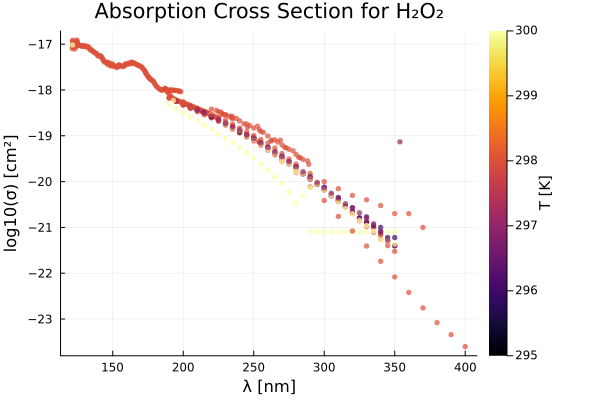

In [6]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

savefig("O3_p2.png")

display(p2)

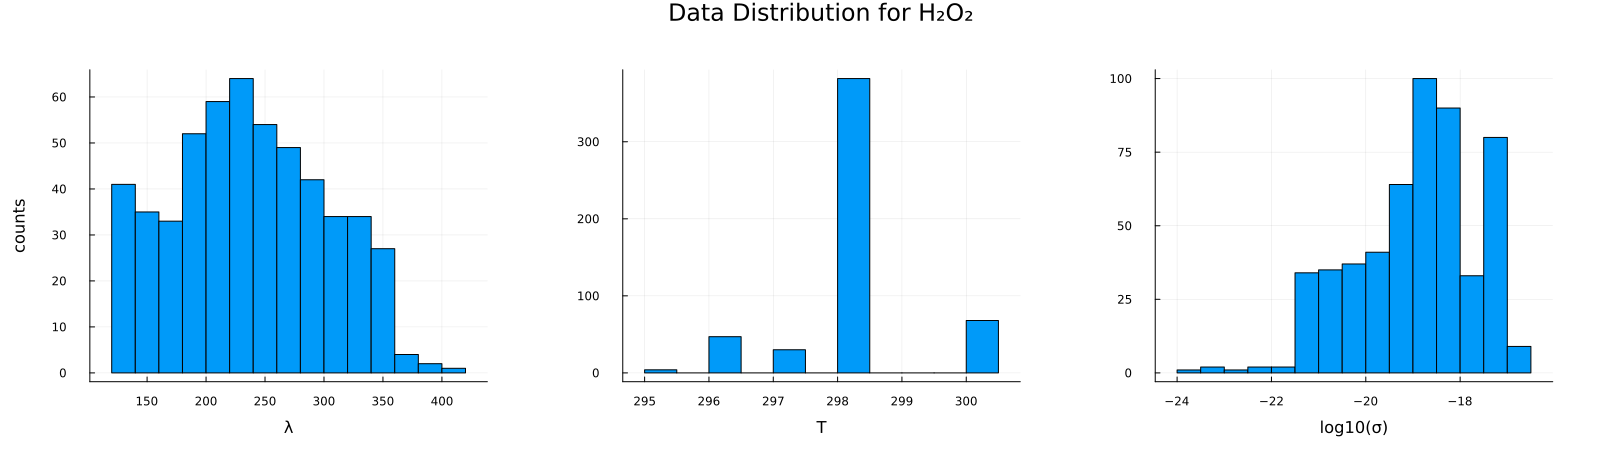

In [7]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="",)
p2 = histogram(df.T, xlabel="T", label="",)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="",)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450),  margin=10Plots.mm, plot_title="Data Distribution for $(nice_name)")

In [8]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [9]:
# deal with identical wavelength records 

gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,220.0,2.6e-19,295.0
2,230.0,1.9e-19,295.0
3,240.0,1.2e-19,295.0
4,250.0,9.0e-20,295.0
5,195.0,5.65e-19,296.0
6,200.0,4.83e-19,296.0
7,205.0,4.21e-19,296.0
8,210.0,3.73e-19,296.0
9,215.0,3.11e-19,296.0


In [10]:
# here is where we would do representative subsampling if there are too many records (> 2000) 
df_sampled = df_unique

min_data_λ = minimum(df_sampled.λ)
max_data_λ = maximum(df_sampled.λ)


400.0

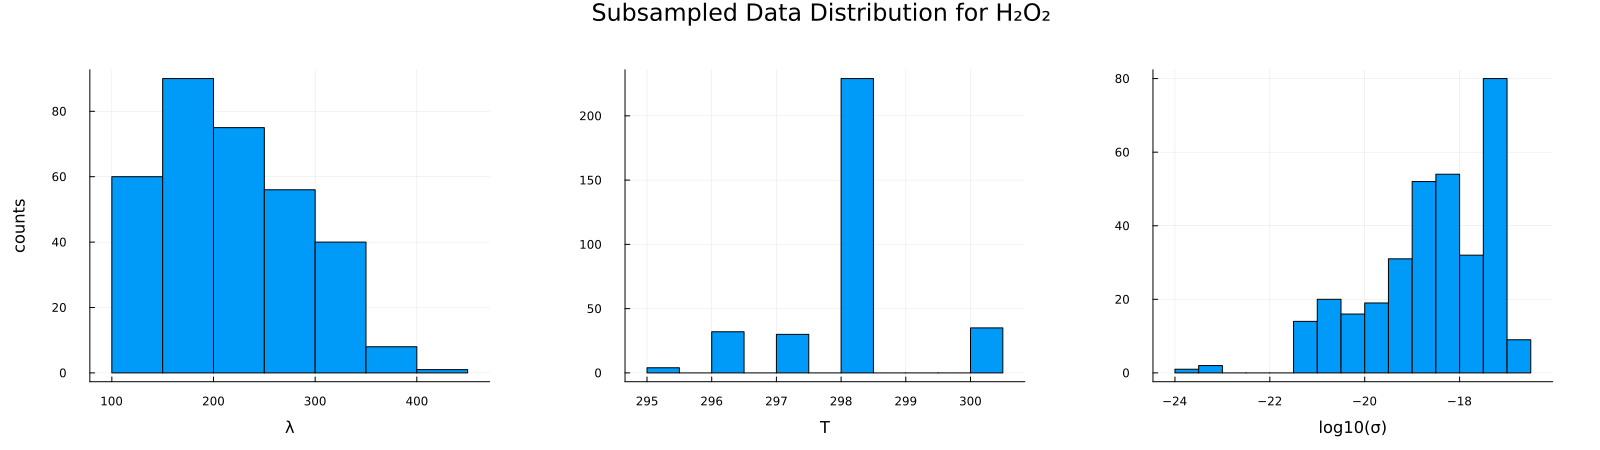

In [11]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

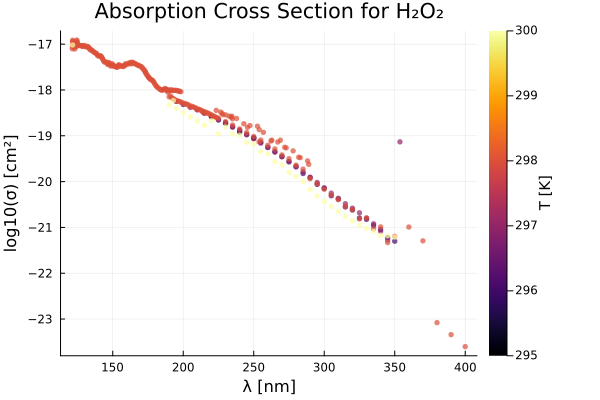

In [12]:
# visualize pre-processed data: 
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

In [13]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))

idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

# gpr = GPR(σ²=0.00001)
gpr = GPR(σ²=30.0)
# gpr = GPR(σ²=10.0)

mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0     2.339459e+03     1.119428e+03
 * time: 0.01784205436706543
     1     2.263134e+03     1.563192e+02
 * time: 1.153212070465088
     2     5.358080e+02     6.589052e+01
 * time: 1.2457399368286133
     3     5.557835e+00     9.721013e+01
 * time: 1.2981090545654297
     4    -3.248790e+01     1.325964e+02
 * time: 1.4459540843963623
     5    -6.917343e+01     1.952835e+01
 * time: 1.4795260429382324
     6    -7.838206e+01     6.355420e+01
 * time: 1.5386290550231934
     7    -8.047555e+01     1.777626e+01
 * time: 1.5724310874938965
     8    -8.727783e+01     3.495200e+01
 * time: 1.6226129531860352
     9    -9.185591e+01     8.238827e+00
 * time: 1.689121961593628
    10    -9.216887e+01     2.850202e+00
 * time: 1.73956298828125
    11    -9.217843e+01     1.487600e+00
 * time: 1.7900009155273438
    12    -9.217925e+01     5.128405e-02
 * time: 1.8283519744873047
    13    -9.217925e+01     1.579888e-03
 * time: 1.8859879970550

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @940 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @987 ⏎ AbstractVector{Continuous}


In [14]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/QZRtR/src/args.jl:1548


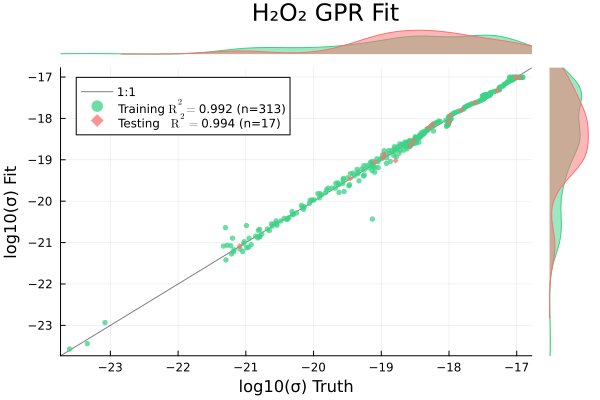

In [15]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)

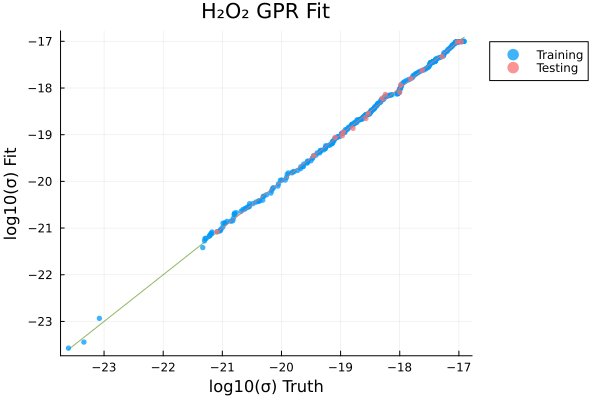

In [16]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


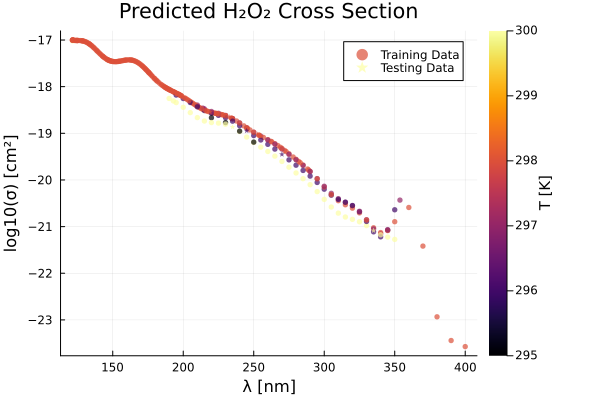

In [17]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)

194.249
400.0


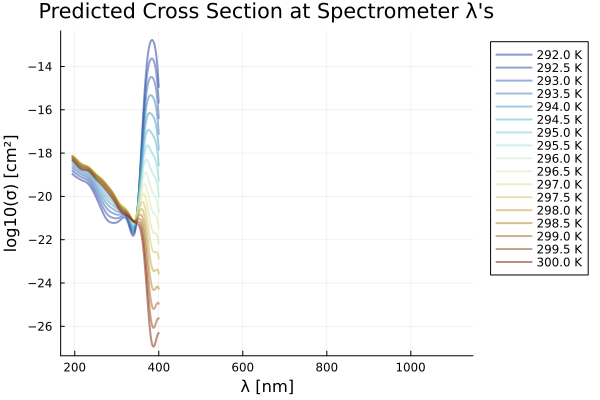

In [18]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

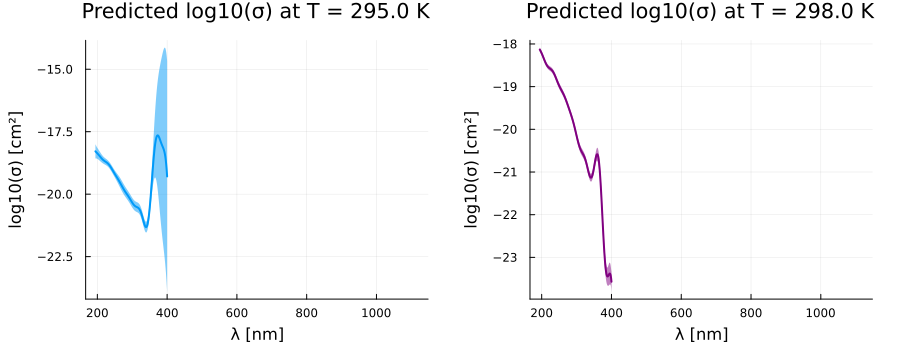

In [19]:
Tplot = 295.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 